# Laboratorium 3 - segmentacja

## Przygotowanie

 * pobierz i wypakuj dataset: https://data.world/socialmediadata/beeradvocate
 * [opcjonalnie] utwórz wirtualne środowisko:
 `python3 -m venv ./recsyslab3`
 * zainstaluj potrzebne biblioteki:
 `pip install gensim==3.8.3 scikit-learn==1.3.2 wordcloud==1.8.1`

## Część 1. - przygotowanie danych

In [1]:
# importujemy potrzebne pakiety
from collections import Counter, defaultdict
import codecs
import csv

from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering # w tym pakiecie są też inne algorytmy
from sklearn.metrics import silhouette_score, silhouette_samples
from wordcloud import WordCloud

In [2]:
PATH = 'socialmediadata-beeradvocate/data/beer_reviews.csv'
POSITIVE_SCORE_THRESHOLD = 4 # recenzje z co najmniej taką oceną weźmiemy pod uwagę
NEGATIVE_SCORE_THRESHOLD = 2 # recenzje z tą wartością lub poniżej weźmiemy jako przykłady negatywne
ACTIVITY_THRESHOLD = 3 # minimalna liczba pozytywnych lub negatywnych recenzji per użytkownik
MIN_SCORES_COUNT = 1 # minimalna liczba ocen pojedynczego elementu
VECTOR_SIZE = 20 # jak długie powinny być wektory osadzeń użytkowników
SEGMENTS_COUNT = 10 # na ile segmentów chcemy podzielić populację użytkowników

In [3]:
# wczytujemy dane
def parse_headers(column_names):
    beer_id_column = column_names.index('beer_beerid')
    beer_style_column = column_names.index('beer_style')
    user_id_column = column_names.index('review_profilename')
    score_column = column_names.index('review_overall')

    return beer_id_column, beer_style_column, user_id_column, score_column


def parse_review(line, beer_id_column, beer_style_column, user_id_column, score_column):
    return (
        line[beer_id_column], 
        line[beer_style_column], 
        line[user_id_column], 
        float(line[score_column])
    )


def read_and_parse_reviews():
    with codecs.open(PATH, 'r', 'UTF-8') as datafile:
        datareader = csv.reader(datafile)
        beer_id_column, beer_style_column, user_id_column, score_column = parse_headers(
            next(datareader)
        )
    
        users_favourite_beers = defaultdict(list)
        users_hated_beers = defaultdict(list)

        for review in datareader:
            beer_id, _, user_id, score = parse_review(
                review, beer_id_column, beer_style_column, user_id_column, score_column
            )
            
            if score >= POSITIVE_SCORE_THRESHOLD:
                users_favourite_beers[user_id].append(beer_id)
            elif score <= NEGATIVE_SCORE_THRESHOLD:
                users_hated_beers[user_id].append(beer_id)

    return users_favourite_beers, users_hated_beers


def get_beer_id_to_style_mapping():
    with codecs.open(PATH, 'r', 'UTF-8') as datafile:
        datareader = csv.reader(datafile)
        beer_styles = {}
        beer_id_column, beer_style_column, user_id_column, score_column = parse_headers(
            next(datareader)
        )

        for review in datareader:
            beer_id, beer_style, _, _ = parse_review(
                review, beer_id_column, beer_style_column, user_id_column, score_column
            )

            beer_styles[beer_id] = beer_style
        
        return beer_styles


# otrzymujemy słownik - mapowanie z user_id na listę ulubionych beer_ids
# podobnie słownik z mapowaniem dla listy nielubianych piw 
users_favourite_beers, users_hated_beers = read_and_parse_reviews()

# dodatkowo przygotujmy sobie słownik mapujący id piwa na nazwę stylu
beer_styles = get_beer_id_to_style_mapping()

## Część 2. - osadzenia użytkowników

In [4]:
# trenujemy model osadzający piwa i użytkowników w przestrzeni
model = Word2Vec(
    sentences=users_favourite_beers.values(), 
    vector_size=VECTOR_SIZE, 
    window=5, 
    min_count=MIN_SCORES_COUNT, 
    workers=4
)

In [5]:
# na podstawie modelu obliczamy wektorową reprezentację użytkowników
def get_mean_vector_for_user(user_favourite_beers, model):
    # inicjalizujemy wektor zerami
    v = np.zeros(VECTOR_SIZE)
    
    # iterujemy po liście user_favourite_beers, odczytujemy z modelu wektor 
    # reprezentujący każde piwo i dodajemy do wektora; użyj: model.wv[beer_id]
    for beer_id in user_favourite_beers:
        v += model.wv[beer_id]
    
    # normalizujemy wektor - dzielimy każdą współrzędną przez liczbę piw
    v /= len(user_favourite_beers)

    return v
    

def get_mean_user_vectors(users_favourite_beers, model):
    # korzystając z powyższej funkcji, tworzymy słownik {user_id -> vector}
    mean_users_vectors = {}

    for user in users_favourite_beers:
        mean_users_vectors[user] = get_mean_vector_for_user(
            users_favourite_beers[user], model
        )
    
    return mean_users_vectors


user_vectors = get_mean_user_vectors(users_favourite_beers, model)

## Część 3. - klasteryzacja

In [6]:
# klastrujemy użytkowników - możemy użyć wielu algorytmów, porównaj co najmniej 2 różne
def get_users_segmentation(user_vectors, clustering_algorithm):
    # rozkładamy słownik user_vectors na listę użytkowników i listę wektorów
    # - ważne jest zachowanie tej samej kolejności w obu listach
    users = list(user_vectors.keys())
    vectors = list(user_vectors.values())
    
    # zamieniamy listę wektorów w macierz
    users_array = np.stack(vectors, axis=0)

    # zaimplementuj wsparcie dla co najmniej dwóch algorytmów
    if clustering_algorithm == 'kmeans':
        segments = KMeans(n_clusters=SEGMENTS_COUNT, random_state=42).fit_predict(users_array)
    elif clustering_algorithm == 'agglomerative':
        segments = AgglomerativeClustering(n_clusters=SEGMENTS_COUNT).fit_predict(users_array)
    else:
        raise ValueError(f'Algorytm "{clustering_algorithm}" nie jest wspierany!')
    
    # jeśli nie pomieszaliśmy kolejności w listach, to możemy odzyskać mapping user_id -> cluster
    segmentation = {}

    for user, segment in zip(users, segments):
        segmentation[user] = segment
    
    return segmentation


segmentation1 = get_users_segmentation(user_vectors, 'kmeans')
segmentation2 = get_users_segmentation(user_vectors, 'agglomerative')

In [7]:
# obliczamy liczności segmentów
def get_segment_sizes(segmentation):
    return Counter(segmentation.values())


print(get_segment_sizes(segmentation1))
print(get_segment_sizes(segmentation2))

Counter({np.int32(0): 10716, np.int32(6): 5963, np.int32(8): 4466, np.int32(7): 1565, np.int32(9): 1529, np.int32(5): 1339, np.int32(2): 1301, np.int32(1): 1301, np.int32(4): 1161, np.int32(3): 945})
Counter({np.int64(3): 13749, np.int64(0): 5710, np.int64(6): 3429, np.int64(2): 1719, np.int64(7): 1632, np.int64(1): 1220, np.int64(5): 780, np.int64(9): 779, np.int64(4): 705, np.int64(8): 563})


In [8]:
# obliczamy metrykę jakości segmentacji
# metryka przyjmuje wartości z przedziału [-1, 1] - im więcej, tym lepiej
users, user_vectors_list = zip(*user_vectors.items())
segments_list1 = [segmentation1[u] for u in users]
segments_list2 = [segmentation2[u] for u in users]

mean_silhouette1 = silhouette_score(user_vectors_list, segments_list1, metric='euclidean')
per_sample_silhouettes1 = silhouette_samples(user_vectors_list, segments_list1, metric='euclidean')

mean_silhouette2 = silhouette_score(user_vectors_list, segments_list2, metric='euclidean')
per_sample_silhouettes2 = silhouette_samples(user_vectors_list, segments_list2, metric='euclidean')

In [9]:
# rysujemy wykres
def plot_histogram(values, mean_value):
    plt.hist(values, color='c', edgecolor='k', alpha=0.65)
    plt.axvline(mean_value, linestyle='dashed', linewidth=1)
    _, plot_height = plt.ylim()
    plt.text(0, plot_height * 1.05, 'Mean: {:.3f}'.format(mean_value))
    plt.show()

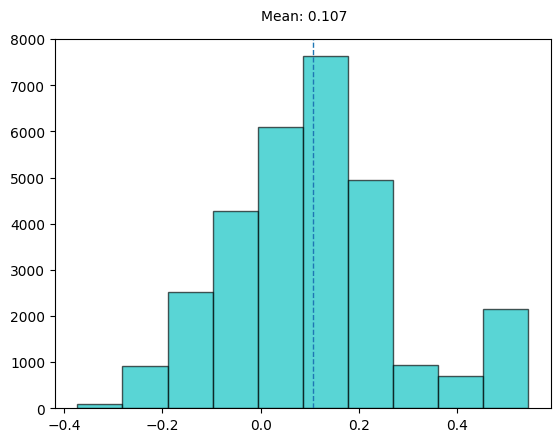

In [10]:
plot_histogram(per_sample_silhouettes1, mean_silhouette1)

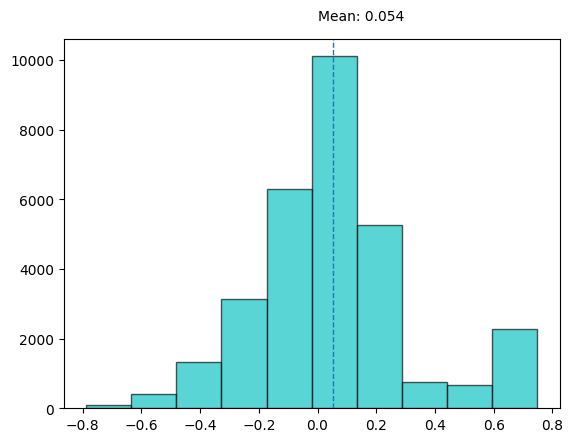

In [11]:
plot_histogram(per_sample_silhouettes2, mean_silhouette2)

## Część 3.5. - negative sampling

Wykonaj kroki obliczania _embeddingów_ (osadzeń) użytkowników, klasteryzacji z użyciem najlepszego według Ciebie algorytmu i obliczania sylwetki - ale tym razem embeddingi to średnia ważona, gdzie elementy `users_favourite_beers[user_id]` mają wagę `1`, a elementy `users_hated_beers[user_id]` mają wagę `-1`.

Możesz także odsiać tych użytkowników, o których wiemy zbyt mało (czyli którzy mają łącznie mniej niż `ACTIVITY_THRESHOLD` elementów w listach `users_favourite_beers[user_id]` i `users_hated_beers[user_id]`).

Pamiętaj, by wykorzystać ten sam wytrenowany już wcześniej model Item2Vec, który oblicza embeddingi poszczególnych elementów.

In [12]:
# na podstawie modelu obliczamy wektorową reprezentację użytkowników
def get_mean_vector_for_user_ns(user_favourite_beers, user_hated_beers, model):
    # inicjalizujemy wektor zerami
    v = np.zeros(VECTOR_SIZE)
    
    # iterujemy po liście user_favourite_beers, odczytujemy z modelu wektor 
    # reprezentujący każde piwo i dodajemy do wektora; użyj: model.wv[beer_id]
    # analogicznie dla user_hated_beers, tyle że odejmujemy
    for beer_id in user_favourite_beers:
        v += model.wv[beer_id]

    for beer_id in user_hated_beers:
        if beer_id in model.wv:
            v -= model.wv[beer_id]
    
    # normalizujemy wektor - dzielimy każdą współrzędną przez liczbę wszystkich piw
    v /= (len(user_favourite_beers) + len(user_hated_beers))

    return v


def get_mean_user_vectors_ns(users_favourite_beers, users_hated_beers, model):
    # korzystając z powyższej funkcji, tworzymy słownik {user_id -> vector}
    mean_users_vectors = {}

    # przygotujmy sobie zbiór wszystkich użytkowników
    all_users = set(list(users_favourite_beers.keys()) + list(users_hated_beers.keys()))

    for user in all_users:
        # obliczamy liczbę lubianych i nielubianych piw
        num_hated_beers = 0 if user not in users_hated_beers else len(users_hated_beers[user])
        num_favorite_beers = 0 if user not in users_favourite_beers\
            else len(users_favourite_beers[user])

        # sprawdzamy, czy nie wiemy zbyt mało o użytkowniku
        if num_favorite_beers + num_hated_beers >= ACTIVITY_THRESHOLD:
            mean_users_vectors[user] = get_mean_vector_for_user_ns(
                [] if num_favorite_beers == 0 else users_favourite_beers[user],
                [] if num_hated_beers == 0 else users_hated_beers[user],
                model
            )
    
    return mean_users_vectors


user_vectors_ns = get_mean_user_vectors_ns(users_favourite_beers, users_hated_beers, model)

In [13]:
segmentation = get_users_segmentation(user_vectors_ns, 'kmeans')
print(get_segment_sizes(segmentation))

Counter({np.int32(7): 3424, np.int32(3): 3212, np.int32(5): 2895, np.int32(0): 1585, np.int32(4): 1539, np.int32(2): 1092, np.int32(6): 904, np.int32(1): 894, np.int32(9): 894, np.int32(8): 481})


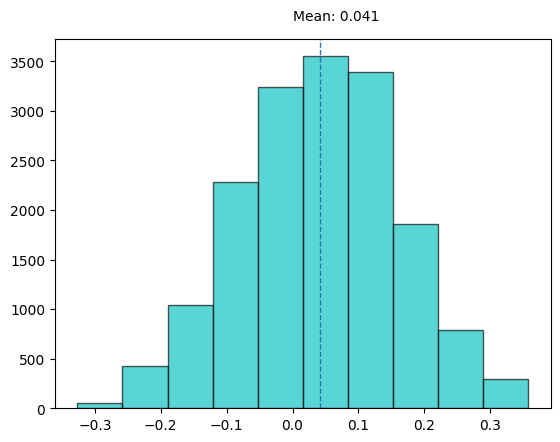

In [14]:
# obliczamy metrykę jakości segmentacji
# metryka przyjmuje wartości z przedziału [-1, 1] - im więcej, tym lepiej
users_ns, user_vectors_list_ns = zip(*user_vectors_ns.items())
segments_list = [segmentation[u] for u in users_ns]
mean_silhouette = silhouette_score(user_vectors_list_ns, segments_list, metric='euclidean')
per_sample_silhouettes = silhouette_samples(user_vectors_list_ns, segments_list, metric='euclidean')
plot_histogram(per_sample_silhouettes, mean_silhouette)

## Część 4. - opisy segmentów

In [15]:
# obliczamy popularność styli w segmentach oraz w całej populacji
# - czyli jak często każdy ze styli występował
def get_per_segment_styles_popularity(users_favourite_beers, beer_styles, segmentation):
    # do tego słownika będziemy się odwoływać np. tak: beer_styles_per_segment[segment][style]
    beer_styles_per_segment = {i: defaultdict(lambda: 0) for i in range(SEGMENTS_COUNT)}
    
    for user, beers in users_favourite_beers.items():
        segment = segmentation[user]

        for beer in beers:
            style = beer_styles[beer]
            beer_styles_per_segment[segment][style] += 1
    
    return beer_styles_per_segment


def get_total_styles_popularity(beer_styles_per_segment):
    total_popularity = defaultdict(lambda: 0)

    for segment_popularity in beer_styles_per_segment.values():
        for style, style_popularity in segment_popularity.items():
            total_popularity[style] += style_popularity
    
    return total_popularity


per_segment_styles_popularity = get_per_segment_styles_popularity(
    users_favourite_beers, beer_styles, segmentation1
)

total_styles_popularity = get_total_styles_popularity(per_segment_styles_popularity)

In [16]:
# przygotujmy dwa opisy segmentów - top N najpopularniejszych stylów w każdym segmencie
# oraz top N unikalnych - to samo, ale popularność w segmencie dzielimy przez łączną popularność
# dla potrzeb wizualizacji w następnym kroku, zwróć słownik {segment_id -> {style_id -> frequency}}
def most_popular_styles_per_segment(per_segment_styles_popularity, N):
    top_styles_per_segment = {i: defaultdict(lambda: 0) for i in range(SEGMENTS_COUNT)}

    for segment, popularity in per_segment_styles_popularity.items():
        top_styles_items = sorted(popularity.items(), key=lambda item: item[1], reverse=True)[:N]

        for style, style_popularity in top_styles_items:
            top_styles_per_segment[segment][style] = style_popularity

    return top_styles_per_segment


def most_distinctive_styles_per_segment(total_styles_popularity, per_segment_styles_popularity, N):
    top_distinctive_styles_per_segment = {i: defaultdict(lambda: 0) for i in range(SEGMENTS_COUNT)}

    for segment, popularity in per_segment_styles_popularity.items():
        distinctive_items = [
            (item[0], float(item[1]) / total_styles_popularity[item[0]]) for item in popularity.items()
        ]

        top_styles_distinctive_items = sorted(
            distinctive_items, key=lambda item: item[1], reverse=True
        )[:N]

        for style, distinctive_style_popularity in top_styles_distinctive_items:
            top_distinctive_styles_per_segment[segment][style] = distinctive_style_popularity

    return top_distinctive_styles_per_segment


top_N = 50
most_popular = most_popular_styles_per_segment(per_segment_styles_popularity, top_N)
most_distinctive = most_distinctive_styles_per_segment(
    total_styles_popularity, per_segment_styles_popularity, top_N
)

## Część 5. - wizualizacja

In [17]:
# teraz możemy zwizualizować nasze segmentacje za pomocą word clouds
# zauważ, jak różnią się obie metody opisów segmentów oraz opisy między poszczególnymi segmentami
def visualise_styles(most_popular, most_distinctive, segment_id):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    wordcloud1 = WordCloud(random_state=42, background_color='black', colormap='Set2')
    wordcloud1.generate_from_frequencies(frequencies=most_popular[segment_id])
    ax1.imshow(wordcloud1, interpolation="bilinear")

    wordcloud2 = WordCloud(random_state=42, background_color='black', colormap='Set2')
    wordcloud2.generate_from_frequencies(frequencies=most_distinctive[segment_id])
    ax2.imshow(wordcloud2, interpolation="bilinear")
    
    ax1.axis("off")
    ax2.axis("off")
    plt.show()

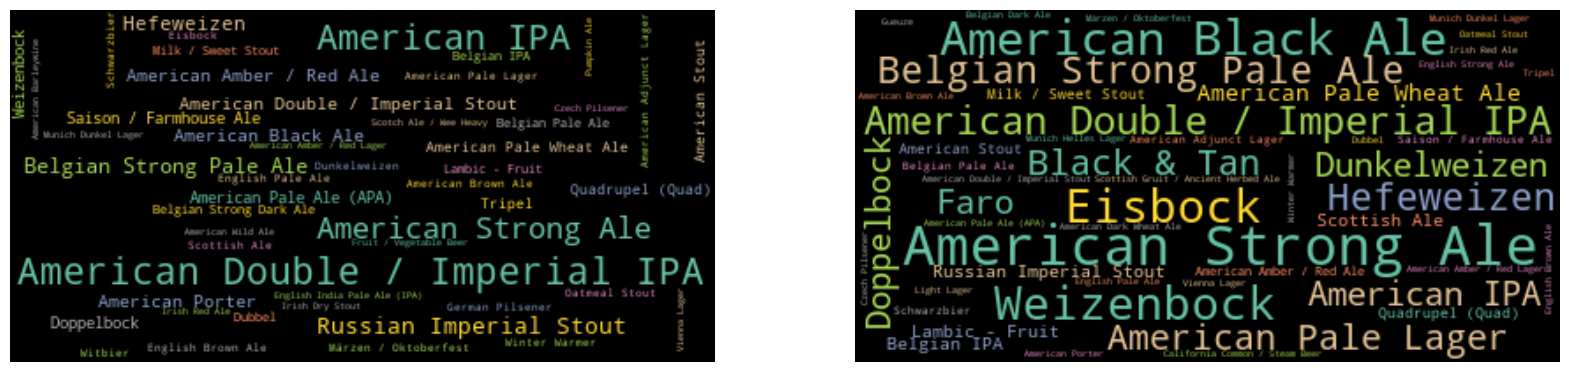

In [18]:
visualise_styles(most_popular, most_distinctive, 1)

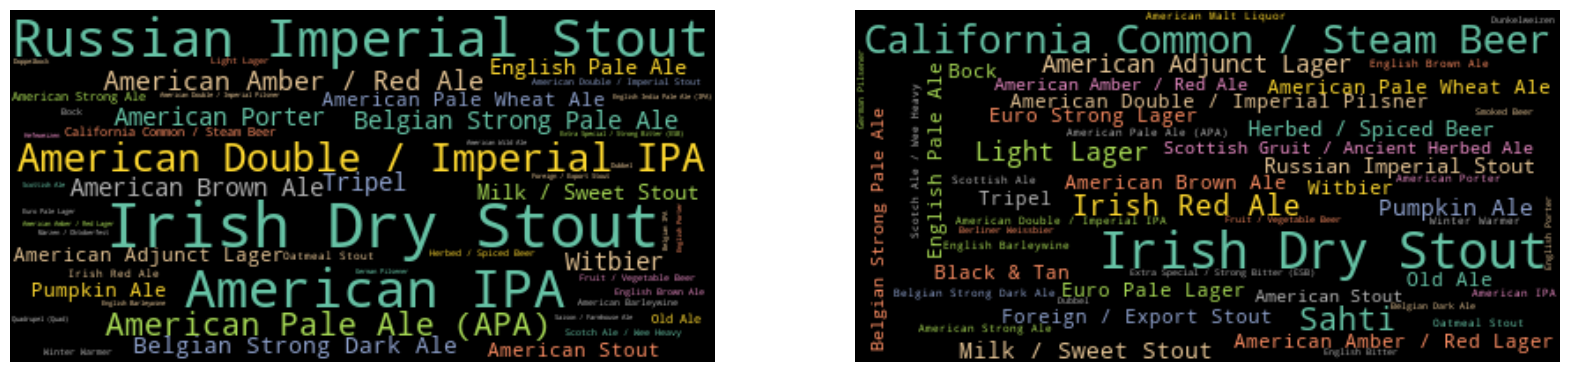

In [19]:
visualise_styles(most_popular, most_distinctive, 3)